TEMPERATURE PREDICTION USING BIDIRECTIONAL LSTM

In [1]:
# Importing library to read the temperature data
import pandas as pd

In [2]:
# Reading the Dataset
#df=pd.read_csv('../input/delhi-weather-data/testset.csv')
df=pd.read_csv('../Dataset/testset.csv')

In [3]:
# A view at the dataset
df.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [4]:
len(df)

100990

In [5]:
# Generating dataframe with temp column and datetime_utc as index
data = pd.DataFrame(list(df[' _tempm']), index=df['datetime_utc'], columns=['temp'])

In [6]:
# A view at the dataframe
data

,temp
datetime_utc,
19961101-11:00,30.0
19961101-12:00,28.0
19961101-13:00,24.0
19961101-14:00,24.0
19961101-16:00,23.0
...,...
20170424-06:00,34.0
20170424-09:00,38.0
20170424-12:00,36.0


In [7]:
data.shape

(100990, 1)

In [8]:
data.isnull().sum()

temp    673
dtype: int64

In [9]:
# Getting rid of null data
df=data.dropna(axis=0)

In [10]:
df.shape

(100317, 1)

In [11]:
df=df['temp'].values

In [12]:
# Transforming df for scaling
df=df.reshape(-1,1)

In [13]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df)

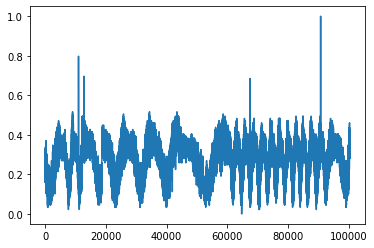

In [14]:
# Plotting the scaled data
import matplotlib.pyplot as plt
plt.plot(data_scaled)

In [15]:
##splitting dataset into train and test split
training_size=int(len(data_scaled)*0.75)
test_size=len(data_scaled)-training_size
train_data,test_data=data_scaled[0:training_size,:],data_scaled[training_size:len(data_scaled),:1]

In [16]:
training_size,test_size

(75237, 25080)

In [17]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape), print(y_train.shape)

(75136, 100)
(75136,)


(None, None)

In [20]:
print(X_test.shape), print(ytest.shape)

(24979, 100)
(24979,)


(None, None)

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
### Create the Bidirectional LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

In [23]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

2022-04-09 10:14:55.663473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 10:14:55.739922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 10:14:55.740724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 10:14:55.741969: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 71,101
Trainable params: 71,101
Non-trainable params: 0
_________________________________________________________________


In [26]:
from keras.callbacks import ModelCheckpoint

In [27]:
# Filepath to save the best model with epoch and val_loss
filepath = './my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

In [28]:
# adding model checkpoint to monitor the val_loss and save the best model based on minimum val_loss to filepath
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [29]:
# Setting callbacks as checkpoint
callbacks = [checkpoint]

In [36]:
# Fitting the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=5,batch_size=64,verbose=1,callbacks=callbacks)

Epoch 1/5
1174/1174 [==============================] - 25s 21ms/step - loss: 3.2474e-04 - val_loss: 8.0896e-04

Epoch 00001: val_loss improved from inf to 0.00081, saving model to ./my_best_model.epoch01-loss0.00.hdf5
Epoch 2/5
1174/1174 [==============================] - 25s 21ms/step - loss: 3.1973e-04 - val_loss: 8.0662e-04

Epoch 00002: val_loss improved from 0.00081 to 0.00081, saving model to ./my_best_model.epoch02-loss0.00.hdf5
Epoch 3/5
1174/1174 [==============================] - 24s 21ms/step - loss: 3.1253e-04 - val_loss: 7.3930e-04

Epoch 00003: val_loss improved from 0.00081 to 0.00074, saving model to ./my_best_model.epoch03-loss0.00.hdf5
Epoch 4/5
1174/1174 [==============================] - 25s 21ms/step - loss: 3.1062e-04 - val_loss: 7.3249e-04

Epoch 00004: val_loss improved from 0.00074 to 0.00073, saving model to ./my_best_model.epoch04-loss0.00.hdf5
Epoch 5/5
1174/1174 [==============================] - 25s 21ms/step - loss: 3.0795e-04 - val_loss: 7.1951e-04

Epoc

In [38]:
# Comparing a random predicted value with the expected one
print("Predicted Value",model.predict(X_train)[4][0])
print("Expected value",y_train[4])

Predicted Value 0.26747555
Expected value 0.2696629213483146


In [40]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [41]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

26.436103029012504

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

26.23806085565778

In [48]:
import numpy as np

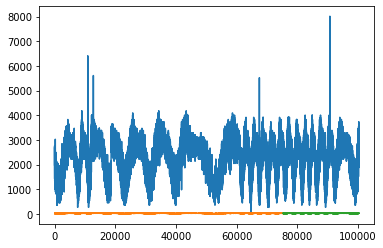

In [49]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [50]:
len(test_data)

25080

In [51]:
x_input=test_data[24715:].reshape(1,-1)
x_input.shape

(1, 365)

In [52]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [56]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=365
i=0
while(i<30):
    
    if(len(temp_input)>365):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.15730337 0.15730337 0.17977528 0.29213483 0.3258427  0.3258427
 0.31460674 0.31460674 0.24719101 0.2247191  0.20224719 0.16853933
 0.16853933 0.19101124 0.20224719 0.26966292 0.29213483 0.28089888
 0.23595506 0.2247191  0.20224719 0.14606742 0.19101124 0.28089888
 0.31460674 0.31460674 0.3258427  0.3258427  0.3258427  0.31460674
 0.30337079 0.23595506 0.20224719 0.17977528 0.17977528 0.21348315
 0.2247191  0.25842697 0.26966292 0.26966292 0.29213483 0.29213483
 0.29213483 0.31460674 0.31460674 0.3258427  0.31460674 0.30337079
 0.28089888 0.24719101 0.21348315 0.17977528 0.17977528 0.20224719
 0.26966292 0.30337079 0.3258427  0.31460674 0.25842697 0.21348315
 0.19101124 0.17977528 0.23595506 0.3258427  0.35955056 0.34831461
 0.26966292 0.2247191  0.21348315 0.21348315 0.24719101 0.35955056
 0.38202247 0.37078652 0.29213483 0.25842697 0.23595506 0.21348315
 0.24719101 0.35955056 0.40449438 0.38202247 0.30337079 0.26966292
 0.24719101 0.2247191  0.26966292 0.31460674 0.3370

In [65]:
df2=df.tolist()
df2.extend(lst_output)


In [66]:
# Transforming back to original form
df3=scaler.inverse_transform(df2).tolist()

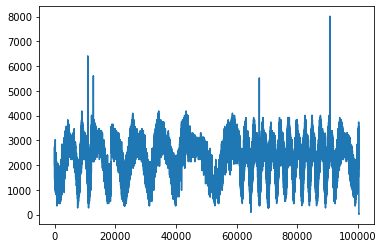

In [67]:
# Plotting the predicted temperature
plt.plot(df3)